In [2]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torchvision import transforms
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from adopt import ADOPT

In [3]:
batch_size = 512
num_epochs = 300
lr = 0.01

In [4]:
train_dataset = FashionMNIST(root='./data', train=True,
                             download=True, transform=transforms.ToTensor())
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
test_dataset = FashionMNIST(root='./data', train=False,
                            download=True, transform=transforms.ToTensor())
test_loader = DataLoader(test_dataset, batch_size)

100%|██████████| 26.4M/26.4M [00:00<00:00, 115MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 4.50MB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 65.3MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 8.18MB/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [5]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(input_dims, hidden_dims)
        self.layer2 = nn.Linear(hidden_dims, hidden_dims)
        self.layer3 = nn.Linear(hidden_dims, hidden_dims)
        self.layer4 = nn.Linear(hidden_dims, hidden_dims)
        self.layer5 = nn.Linear(hidden_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.layer1(x)
        x = self.sigmoid(x)
        x = self.layer2(x)
        x = self.sigmoid(x)
        x = self.layer3(x)
        x = self.sigmoid(x)
        x = self.layer4(x)
        x = self.sigmoid(x)
        x = self.layer5(x)
        x = self.sigmoid(x)
        output = self.output(x)
        return output

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
model = MLP(input_dims=784,
            hidden_dims=128,
            output_dims=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = ADOPT(model.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-6)

In [8]:
train_losses = []
train_acc = []
val_losses = []
val_acc = []

for epoch in range(num_epochs):
    model.train()
    t_loss = 0
    t_acc = 0
    cnt = 0
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        t_loss += loss.item()
        t_acc += (torch.argmax(outputs, 1) == y).sum().item()
        cnt += len(y)
    t_loss /= len(train_loader)
    train_losses.append(t_loss)
    t_acc /= cnt
    train_acc.append(t_acc)

    model.eval()
    v_loss = 0
    v_acc = 0
    cnt = 0
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            loss = criterion(outputs, y)
            v_loss += loss.item()
            v_acc += (torch.argmax(outputs, 1) == y).sum().item()
            cnt += len(y)
        v_loss /= len(test_loader)
        val_losses.append(v_loss)
        v_acc /= cnt
        val_acc.append(v_acc)
    print(f'Epoch {epoch+1}\tTraining Loss: {t_loss:.3f}\tValidation Loss: {v_loss:.3f}')

Epoch 1	Training Loss: 2.341	Validation Loss: 2.305
Epoch 2	Training Loss: 2.305	Validation Loss: 2.304
Epoch 3	Training Loss: 2.305	Validation Loss: 2.303
Epoch 4	Training Loss: 2.304	Validation Loss: 2.306
Epoch 5	Training Loss: 2.303	Validation Loss: 2.313
Epoch 6	Training Loss: 2.306	Validation Loss: 2.304
Epoch 7	Training Loss: 2.235	Validation Loss: 1.792
Epoch 8	Training Loss: 1.966	Validation Loss: 1.740
Epoch 9	Training Loss: 1.623	Validation Loss: 1.547
Epoch 10	Training Loss: 1.512	Validation Loss: 1.505
Epoch 11	Training Loss: 1.544	Validation Loss: 1.490
Epoch 12	Training Loss: 1.475	Validation Loss: 1.477
Epoch 13	Training Loss: 1.471	Validation Loss: 1.471
Epoch 14	Training Loss: 1.477	Validation Loss: 1.472
Epoch 15	Training Loss: 1.463	Validation Loss: 1.459
Epoch 16	Training Loss: 1.417	Validation Loss: 1.379
Epoch 17	Training Loss: 1.372	Validation Loss: 1.480
Epoch 18	Training Loss: 1.361	Validation Loss: 1.359
Epoch 19	Training Loss: 1.346	Validation Loss: 1.350
Ep

Text(0, 0.5, 'Accuracy')

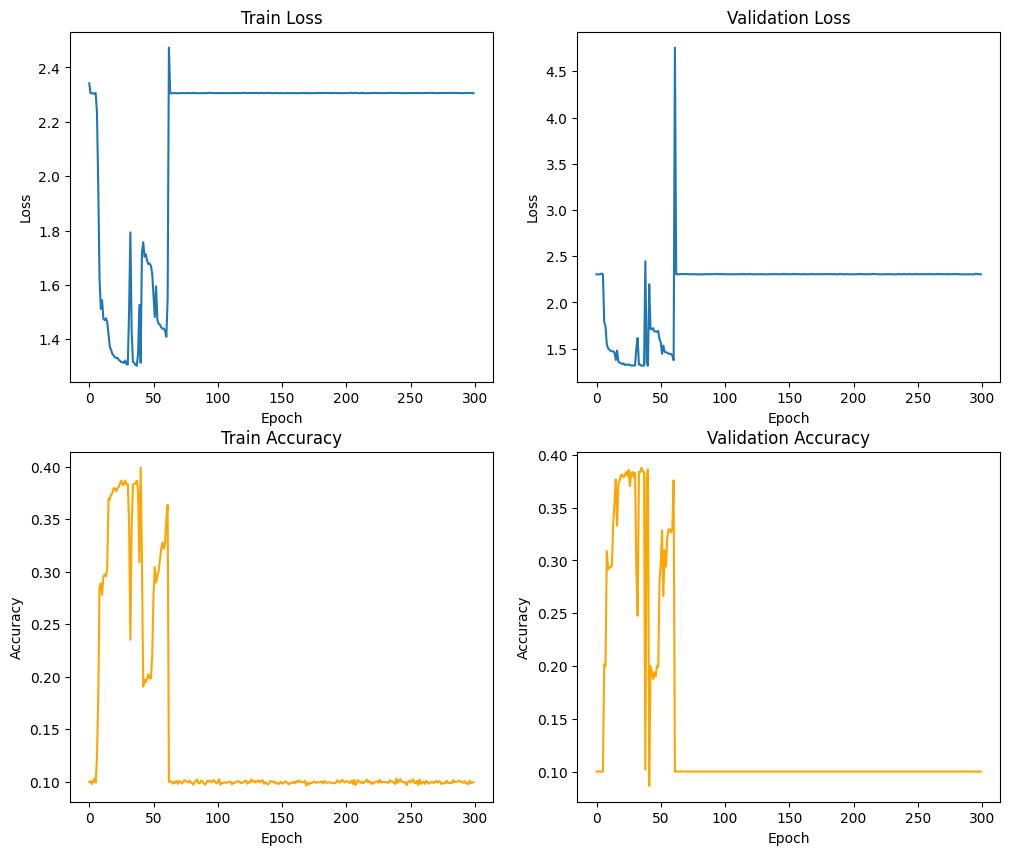

In [13]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

ax[0, 0].plot(train_losses)
ax[0, 0].set_title('Train Loss')
ax[0, 0].set_xlabel('Epoch')
ax[0, 0].set_ylabel('Loss')

ax[0, 1].plot(val_losses)
ax[0, 1].set_title('Validation Loss')
ax[0, 1].set_xlabel('Epoch')
ax[0, 1].set_ylabel('Loss')

ax[1, 0].plot(train_acc, color='orange')
ax[1, 0].set_title('Train Accuracy')
ax[1, 0].set_xlabel('Epoch')
ax[1, 0].set_ylabel('Accuracy')

ax[1, 1].plot(val_acc, color='orange')
ax[1, 1].set_title('Validation Accuracy')
ax[1, 1].set_xlabel('Epoch')
ax[1, 1].set_ylabel('Accuracy')

In [12]:
test_target = []
test_predict = []
with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        outputs = model(X)
        test_target.append(y.cpu())
        test_predict.append(outputs.cpu())

test_predict = torch.cat(test_predict)
test_target = torch.cat(test_target)
acc = (torch.argmax(test_predict, 1) == test_target).sum().item() / len(test_target)
acc

0.1